# This is a basic LSSTM model used to test dataset preperation and model evaluation

## Imports

In [3]:
import torch.nn as nn
import torch
import full_rut_dataset_generator as rut
from training_loop import train_model
import matplotlib.pyplot as plt
import numpy as np

## Constants

- `SEQUENCE_LENGTH` is the number of historical measurements before the target element to provide to the model
- `NUM_FREATURES_PER_SAMPLE` is how many details each measurement has. `IRI-only` has 3: left_iri, right_iri, and time_since_first_measurement
- `NUM_LAYERS` is the number of RNN layers to use

In [4]:
SEQUENCE_LENGTH = 10
NUM_FEATURES_PER_SAMPLE = 14
NUM_LAYERS = 3

## Dataset Preperation

Load train and test datasets

In [6]:
train, test = rut.load_rut_datasets(path="../training_data/final_data.parquet",
                                    construction_path="../training_data/construction_data.parquet",
                                    seq_length=SEQUENCE_LENGTH)

Loading cached data:
train_42_0.8_10_False.parquet
Cached data not found, regenerating...


## Model Definition

Here a basic RNN classifier model is defined.

1. Data is flattened
2. RNN layers process data and modify hidden state
3. final layer maps hidden state to 3 predicted probilities
4. outputs are scaled using a logsoftmax function

In [9]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=SEQUENCE_LENGTH,
                          hidden_size=SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE,
                          num_layers=NUM_LAYERS,
                          batch_first=True)
        self.final = nn.Linear(SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE, 1)

    def forward(self, x):
        hidden = torch.zeros(NUM_LAYERS,
                             x.size(0),
                             SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE).to(x.device)
        cell = torch.zeros(NUM_LAYERS,
                            x.size(0),
                            SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE).to(x.device)
        out, _ = self.rnn(x, (hidden, cell))
        out = self.final(out[:, -1, :])
        return out

## Training

In [10]:
model = LSTM()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

train_info1 = train_model(model, train, test, loss, optimizer, epochs=200, test_every_n=1, batch_size=512, lr_scheduler=lr_scheduler)


In [11]:
print(f"ver1: trainloss: {train_info1['train_losses'][-1]}, testloss: {train_info1['test_losses'][-1]}, trainr2: {train_info1['train_r2s'][-1]}, testr2: {train_info1['test_r2s'][-1]}")

ver1: trainloss: 9.515076404072302e-05, testloss: 0.0001612863389626992, trainr2: 0.9928087092716146, testr2: 0.9864630870876513


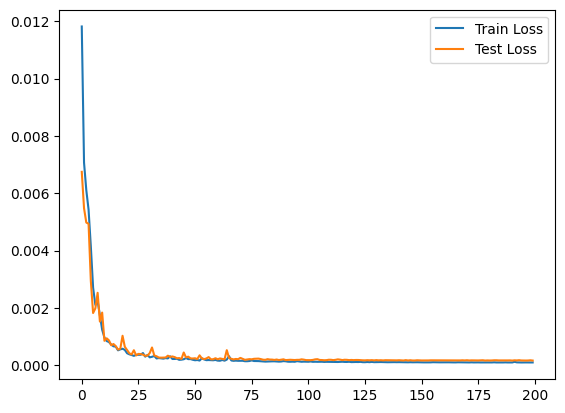

In [12]:
plt.plot(train_info1["train_losses"], label="Train Loss")
plt.plot(train_info1["test_losses"], label="Test Loss")
plt.legend()
plt.show()

## Accuracy Computation

In [14]:
from torcheval.metrics import R2Score
from torch.utils.data import DataLoader

def compute_r2_for(dataset):
    r2 = R2Score()
    train_data = DataLoader(dataset, batch_size=256, shuffle=True)
    for _, data in enumerate(train_data):
        inputs, goal = data[0], data[1]
        outputs = model(inputs)
        r2.update(goal, outputs)
    return r2.compute()

model.to("cpu")
model.eval()
with torch.no_grad():
    train_r2 = compute_r2_for(train)
    print(f"R^2 for training data: {train_r2}")
    test_r2 = compute_r2_for(test)
    print(f"R^2 for testing data: {test_r2}")

R^2 for training data: 0.9929128885269165
R^2 for testing data: 0.9862899780273438


In [15]:
from torcheval.metrics import MeanSquaredError

def compute_mse_for(dataset):
    mse = MeanSquaredError()
    train_data = DataLoader(dataset, batch_size=256, shuffle=True)
    for _, data in enumerate(train_data):
        inputs, goal = data[0], data[1]
        outputs = model(inputs)
        mse.update(outputs, goal)
    return mse.compute()

model.to("cpu")
model.eval()
with torch.no_grad():
    train_mse = compute_mse_for(train)
    print(f"MSE for training data: {train_mse}")
    test_mse = compute_mse_for(test)
    print(f"MSE for testing data: {test_mse}")

MSE for training data: 9.384252189192921e-05
MSE for testing data: 0.00016417923325207084


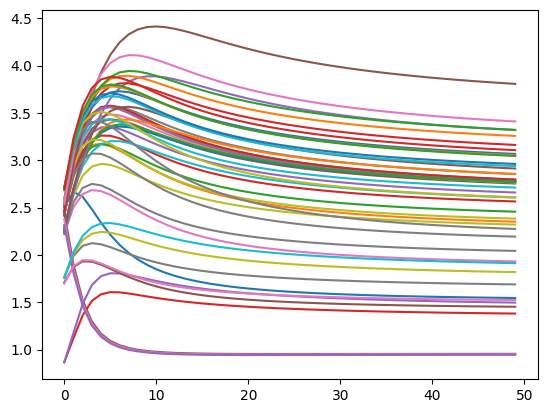

In [17]:
roads = range(0, 500)

#common sense testing
# call the model ith t increments of 360 for 10 timesteps and print the results
allres = []
for i in roads:
    results = []
    inpt = test[i][0]
    for i in range(0, 50):
        inpt[-2, -1] = 1 * i
        results.append(model(inpt.unsqueeze(0)).squeeze() * rut.iri_range + rut.mean_iri)
        results[-1] = results[-1].detach().numpy()
    allres.append(results)
allres = np.array(allres)
for i in range(50):
    plt.plot(allres[i, :], label=f"Road {i}")